## Communicating with the native twitter API (v2)

code partly based on: https://towardsdatascience.com/an-extensive-guide-to-collecting-tweets-from-twitter-api-v2-for-academic-research-using-python-3-518fcb71df2a

In [ ]:
import os
import requests
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time

from datetime import datetime, timedelta
from src.config import bearer

In [16]:
def get_date(date):
    ''' The twitter API only accepts dates in a specific format. This function takes care of that.
    insert start_date and end_date in format: yyyy-mm-dd, e.g.,: 2022-06-23'''
    
    dtformat = '%Y-%m-%dT%H:%M:%SZ'
    
    year, month, day = [int(e) for e in date.split('-')]
    date = datetime(year, month, day, 00,0,0000).strftime(dtformat)
    return date


In [9]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [10]:
def create_url(keyword, start_date, end_date, max_results = 200):
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from
    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_time, 
                    'end_time': end_time,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    
    return (search_url, query_params)

In [11]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [35]:
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

### Making a request; getting some data. 
#some information on how to construct queries to communicate with the Twitter API: https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

In [61]:
keyword = 'elfstedentocht OR schaatsen lang:nl'
max_results = 100
start_time = get_date('2022-01-01')
end_time = get_date('2022-01-10')
headers = create_headers(bearer)

#in case you want to make a single request:
#url = create_url('sinterklaas lang:nl', start_time, end_time)
#results = connect_to_endpoint(url[0], headers, url[1], next_token = None)

# Inputs
count = 0 # Counting tweets per time period
#max_count = 100 # Max tweets per time period
flag = True
next_token = None

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open("data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

# Check if flag is true
while flag:
    # Check if max_count reached
   # if count >= max_count:
   #     break
    print("-------------------")
    print("Token: ", next_token)
    url = create_url(keyword, start_time,end_time, max_results)
    json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
    result_count = json_response['meta']['result_count']

    if 'next_token' in json_response['meta']:
        print('yes')
        # Save the token to use for next call
        next_token = json_response['meta']['next_token']
        print("Next Token: ", next_token)
        if result_count is not None and result_count > 0 and next_token is not None:
            print("Start Date: ", start_time)
            append_to_csv(json_response, "data.csv")
            count += result_count
            total_tweets += result_count
            print("Total # of Tweets added: ", total_tweets)
            print("-------------------")
            time.sleep(5)                
    # If no next token exists
    else:
        if result_count is not None and result_count > 0:
            print("-------------------")
            print("Start Date: ", start_time)
            append_to_csv(json_response, "data.csv")
            count += result_count
            total_tweets += result_count
            print("Total # of Tweets added: ", total_tweets)
            print("-------------------")
            time.sleep(5)

        #Since this is the final request, turn flag to false to move to the next time period.
        flag = False
        next_token = None
    time.sleep(5)
print("Total number of results: ", total_tweets)

-------------------
Token:  None
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe4542awfe9rdbpbqq99igmefivzx
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  98
Total # of Tweets added:  98
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe4542awfe9rdbpbqq99igmefivzx
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe45429zpzla6lymqtkk1p0nuek59
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  97
Total # of Tweets added:  195
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe45429zpzla6lymqtkk1p0nuek59
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe45429ecqt9bw16dc3qcqvf5ib25
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  100
Total # of Tweets added:  295
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe45429ecqt9bw16dc3qcqvf5ib25
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe4540729oeraxp3mnu9yf888nm9p
Sta

Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pjezjls56s98dfj9wm4h5aet9
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  99
Total # of Tweets added:  2846
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18pjezjls56s98dfj9wm4h5aet9
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pjeopoukznk48k2xnk3005md9
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  99
Total # of Tweets added:  2945
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18pjeopoukznk48k2xnk3005md9
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pjedx8eswkslevwl25m5w7ddp
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  97
Total # of Tweets added:  3042
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18pjedx8eswkslevwl25m5w7ddp
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pje33aew9xomrq8coh37vw131
Start Date:  2022-01-01T00:00:00Z

-------------------
Token:  b26v89c19zqg8o3fpe18pf41duvh0c22k3umddsez8rr1
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pawzko0iyhudpt0hh0m3a6h6l
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  100
Total # of Tweets added:  5708
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18pawzko0iyhudpt0hh0m3a6h6l
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18paw2yb7pfoh41a3ddy4yncygt
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  100
Total # of Tweets added:  5808
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18paw2yb7pfoh41a3ddy4yncygt
Endpoint Response Code: 200
yes
Next Token:  b26v89c19zqg8o3fpe18pauvpj6ysdzyl08bvbroaxvgd
Start Date:  2022-01-01T00:00:00Z
# of Tweets added from this response:  100
Total # of Tweets added:  5908
-------------------
-------------------
Token:  b26v89c19zqg8o3fpe18pauvpj6ysdzyl08bvbroaxvgd
Endpoint Response Code: 200
yes
Next Token:  b2

## example of visual inspection in terms of trends/ attention for a specific issue over time 
just a very short time frame for now, but you get the idea. 

In [62]:
### read the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv('data.csv')

In [64]:
d = (pd.to_datetime(df['created_at'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('date')
       .reset_index(name='count'))

In [65]:
d

,date,count
0,2022-01-04 00:00:00+00:00,3115
1,2022-01-09 00:00:00+00:00,638
2,2022-01-08 00:00:00+00:00,574
3,2022-01-07 00:00:00+00:00,564
4,2022-01-03 00:00:00+00:00,524
5,2022-01-05 00:00:00+00:00,523
6,2022-01-02 00:00:00+00:00,461
7,2022-01-01 00:00:00+00:00,303
8,2022-01-06 00:00:00+00:00,203


<AxesSubplot:xlabel='date', ylabel='count'>

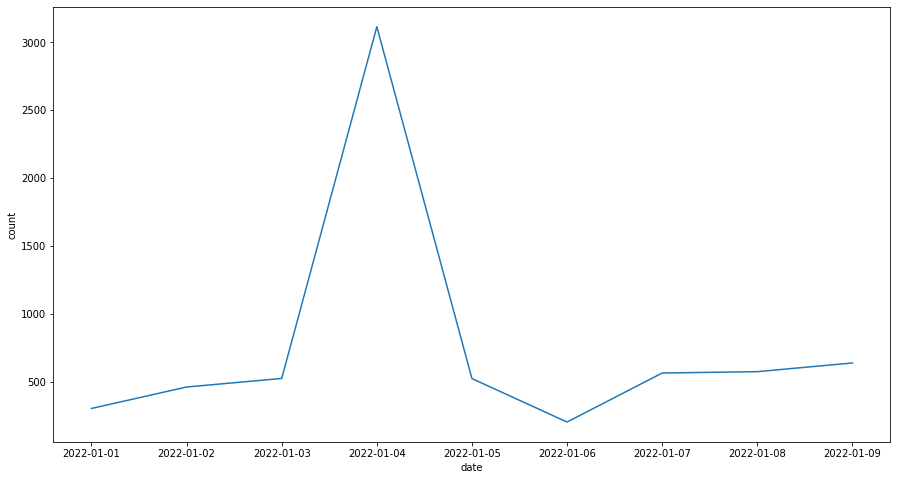

In [66]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'date', y = 'count',data = d)